### finding the best aprameters for LGBoost along with crossvalidation
preprocess v.1

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py

In [2]:
train = pd.read_csv('./processeddata/traindata_no_text_processing.csv')

In [3]:
x = train.iloc[:,0:train.shape[1]-1]
y = train.iloc[:,-1]

In [4]:
## removing title and item_id have already added title features in training set 
x.drop('title',axis = 1, inplace= True)
x.drop('item_id',axis = 1, inplace= True)

In [5]:
x.head()

,category_name,city,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,user_id,user_type,Weekday,Weekend_no,day,image_status,no_of_words_description,no_of_words_title,no_of_chars_title,no_of_chars_description
0,42,462,12,2,249,112,1217,4,400.0,19,884270,1,1,13,28,1,7,3,38,108
1,22,1314,2722,19,122,112,1217,2,3000.0,17,227908,1,6,12,26,1,7,3,32,73
2,2,1290,2259,9,84,112,1217,0,4000.0,16,576261,1,0,12,20,1,17,2,14,168
3,42,950,2837,286,38,112,1217,4,2200.0,21,755087,0,5,12,25,1,3,1,20,38
4,0,318,1407,3,278,124,46,6,40000.0,4,944363,1,3,11,16,1,4,3,17,44


In [6]:
test = pd.read_csv('./processeddata/testdata_no_text_processing.csv')

In [7]:
test.drop('title',axis = 1, inplace= True)
test.drop('item_id',axis = 1, inplace= True)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
print('Start training...')
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Start training...
[1]	valid_0's l1: 0.188382
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.186751
[3]	valid_0's l1: 0.18524
[4]	valid_0's l1: 0.183831
[5]	valid_0's l1: 0.182574
[6]	valid_0's l1: 0.181451
[7]	valid_0's l1: 0.180423
[8]	valid_0's l1: 0.179479
[9]	valid_0's l1: 0.178555
[10]	valid_0's l1: 0.177716
[11]	valid_0's l1: 0.176897
[12]	valid_0's l1: 0.176119
[13]	valid_0's l1: 0.175403
[14]	valid_0's l1: 0.174724
[15]	valid_0's l1: 0.174053
[16]	valid_0's l1: 0.173445
[17]	valid_0's l1: 0.17287
[18]	valid_0's l1: 0.172323
[19]	valid_0's l1: 0.171775
[20]	valid_0's l1: 0.171281
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.171281


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=20,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [12]:
print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


Start predicting...
('The rmse of prediction is:', 0.24046318187730062)


In [13]:
# feature importances
print('Feature importances:', list(gbm.feature_importances_))

('Feature importances:', [114, 0, 68, 32, 149, 67, 23, 50, 50, 0, 0, 24, 0, 0, 0, 0, 6, 1, 2, 14])


In [15]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [15]:
print('Start training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)


Start training with custom eval function...
[1]	valid_0's l2: 0.066486	valid_0's RMSLE: 0.192983
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0655764	valid_0's RMSLE: 0.19143
[3]	valid_0's l2: 0.0647542	valid_0's RMSLE: 0.190033
[4]	valid_0's l2: 0.0640017	valid_0's RMSLE: 0.188753
[5]	valid_0's l2: 0.0633175	valid_0's RMSLE: 0.187596
[6]	valid_0's l2: 0.0627052	valid_0's RMSLE: 0.186565
[7]	valid_0's l2: 0.0621382	valid_0's RMSLE: 0.185617
[8]	valid_0's l2: 0.0616337	valid_0's RMSLE: 0.184775
[9]	valid_0's l2: 0.0611541	valid_0's RMSLE: 0.183977
[10]	valid_0's l2: 0.0607384	valid_0's RMSLE: 0.18329
[11]	valid_0's l2: 0.0603267	valid_0's RMSLE: 0.182613
[12]	valid_0's l2: 0.0599421	valid_0's RMSLE: 0.181983
[13]	valid_0's l2: 0.0595967	valid_0's RMSLE: 0.181425
[14]	valid_0's l2: 0.0592804	valid_0's RMSLE: 0.180913
[15]	valid_0's l2: 0.0589737	valid_0's RMSLE: 0.180412
[16]	valid_0's l2: 0.0586985	valid_0's RMSLE: 0.179976
[17]	valid_0's l2: 0.058451

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=20,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [16]:
print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Start predicting...
('The rmsle of prediction is:', 0.17859567816808178)


In [17]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

In [18]:
%%time 
gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

('Best parameters found by grid search are:', {'n_estimators': 40, 'learning_rate': 1})
CPU times: user 4min 27s, sys: 28.2 s, total: 4min 55s
Wall time: 2min 17s


In [21]:
# other scikit-learn modules
estimator2 = lgb.LGBMRegressor(num_leaves=31)

param_grid2 = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40, 60, 80]
}

In [22]:
%%time 
gbm2 = GridSearchCV(estimator2, param_grid2)

gbm2.fit(X_train, y_train,verbose=20)

print('Best parameters found by grid search are:', gbm2.best_params_)

('Best parameters found by grid search are:', {'n_estimators': 40, 'learning_rate': 1})
CPU times: user 11min 47s, sys: 1min 11s, total: 12min 58s
Wall time: 6min 3s


In [10]:
## from here
gbm_best = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=1,
                        n_estimators=40)

In [14]:
%%time
gbm_best.fit(x, y,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

[1]	valid_0's l2: 0.0571882	valid_0's RMSLE: 0.178462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0559672	valid_0's RMSLE: 0.176697
[3]	valid_0's l2: 0.055326	valid_0's RMSLE: 0.175688
[4]	valid_0's l2: 0.0550517	valid_0's RMSLE: 0.175184
[5]	valid_0's l2: 0.0547672	valid_0's RMSLE: 0.174779
[6]	valid_0's l2: 0.0546017	valid_0's RMSLE: 0.174534
[7]	valid_0's l2: 0.0544186	valid_0's RMSLE: 0.174251
[8]	valid_0's l2: 0.0542084	valid_0's RMSLE: 0.173926
[9]	valid_0's l2: 0.053964	valid_0's RMSLE: 0.173556
[10]	valid_0's l2: 0.0538767	valid_0's RMSLE: 0.173408
[11]	valid_0's l2: 0.0537183	valid_0's RMSLE: 0.173171
[12]	valid_0's l2: 0.0536088	valid_0's RMSLE: 0.173
[13]	valid_0's l2: 0.0535058	valid_0's RMSLE: 0.172845
[14]	valid_0's l2: 0.0534141	valid_0's RMSLE: 0.172692
[15]	valid_0's l2: 0.0533416	valid_0's RMSLE: 0.172553
[16]	valid_0's l2: 0.0532635	valid_0's RMSLE: 0.172439
[17]	valid_0's l2: 0.0531934	valid_0's RMSLE: 0.172331
[18]	valid_0's l2:

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=40,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [15]:
%%time
predcited_test_lgb = gbm_best.predict(test, num_iteration=40)


CPU times: user 2.5 s, sys: 253 ms, total: 2.75 s
Wall time: 1.14 s


In [16]:
predcited_test_lgb.shape

(508438,)

In [38]:
testdata = pd.read_csv('test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdatai = testdata.index

In [39]:
lgboop = pd.DataFrame(predcited_test_lgb,columns=["deal_probability"],index=testdatai)

In [40]:
lgboop["deal_probability"] = lgboop["deal_probability"].clip(0.0, 1.0 ) # Between 0 and 1



In [41]:
print all(i > 1.0 for i in lgboop.values)
print all(i < .0 for i in lgboop.values)

False
False


In [42]:
lgboop.to_csv("./processeddata/lgb_op_cv.csv",index=True,header=True)

In [43]:
lgboop.head()

,deal_probability
item_id,
6544e41a8817,0.102036
65b9484d670f,0.308063
8bab230b2ecd,0.260494
8e348601fefc,0.129886
8bd2fe400b89,0.276928


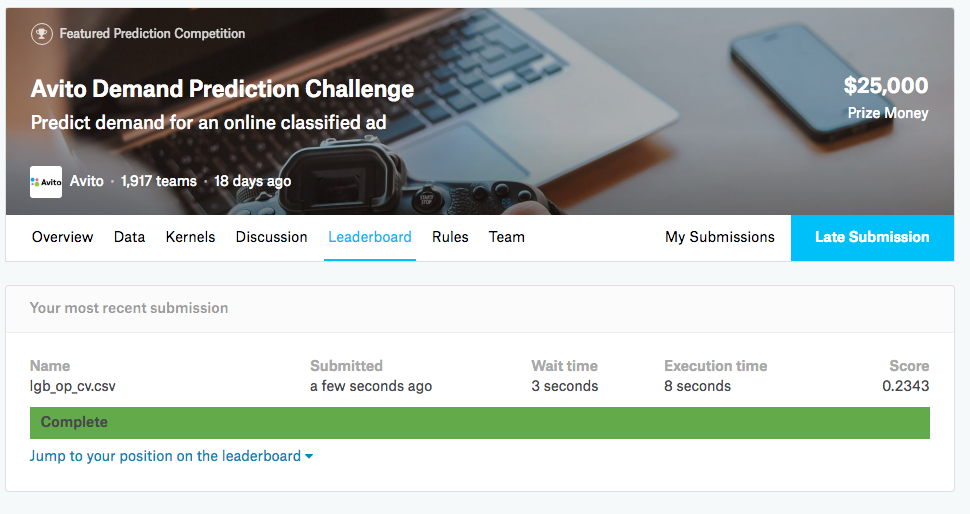

In [44]:
from IPython.display import Image
Image("./processeddata/images/LB_cv.png")

Plot feature importances...


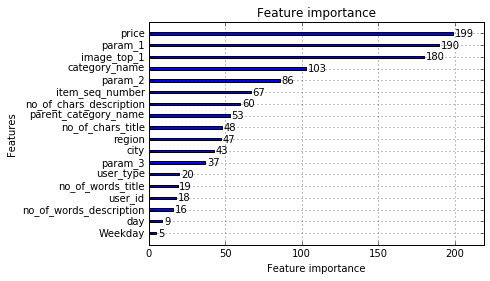

In [18]:
import matplotlib.pyplot as plt
print('Plot feature importances...')
ax = lgb.plot_importance(gbm_best, max_num_features=18)
plt.show()

In [19]:
import matplotlib
print('Plot 35th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm_best, tree_index=35, figsize=(80, 32), show_info=['split_gain'])
plt.savefig('./processeddata/images/35.png')

#fig.savefig('./processeddata/35.png')   # save the figure to file
#plt.close(fig)    # close the figure



Plot 35th tree...


In [8]:
## remove some features                                                                                                 
trainless = train.drop(['no_of_words_title','user_id','no_of_words_description','day','Weekday'],axis=1)

In [9]:
trainless.head()

,item_id,category_name,city,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_type,Weekend_no,image_status,no_of_chars_title,no_of_chars_description,deal_probability
0,b912c3c6a6ad,42,462,12,2,249,112,1217,4,400.0,19,Кокоби(кокон для сна),1,13,1,38,108,0.12789
1,2dac0150717d,22,1314,2722,19,122,112,1217,2,3000.0,17,Стойка для Одежды,1,12,1,32,73,0.00000
2,ba83aefab5dc,2,1290,2259,9,84,112,1217,0,4000.0,16,Philips bluray,1,12,1,14,168,0.43177
3,02996f1dd2ea,42,950,2837,286,38,112,1217,4,2200.0,21,Автокресло,0,12,1,20,38,0.80323
4,7c90be56d2ab,0,318,1407,3,278,124,46,6,40000.0,4,"ВАЗ 2110, 2003",1,11,1,17,44,0.20797


In [10]:
x = trainless.iloc[:,0:trainless.shape[1]-1]
y = trainless.iloc[:,-1]
x.drop('title',axis = 1, inplace= True)
x.drop('item_id',axis = 1, inplace= True)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
## from here
gbm_best3 = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=1,
                        n_estimators=40)

In [16]:
%%time
gbm_best3.fit(x, y,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

[1]	valid_0's l2: 0.0571882	valid_0's RMSLE: 0.178462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0559603	valid_0's RMSLE: 0.176695
[3]	valid_0's l2: 0.055347	valid_0's RMSLE: 0.175718
[4]	valid_0's l2: 0.0550838	valid_0's RMSLE: 0.175317
[5]	valid_0's l2: 0.0547301	valid_0's RMSLE: 0.17481
[6]	valid_0's l2: 0.0545019	valid_0's RMSLE: 0.174392
[7]	valid_0's l2: 0.0543146	valid_0's RMSLE: 0.174089
[8]	valid_0's l2: 0.0541915	valid_0's RMSLE: 0.173929
[9]	valid_0's l2: 0.0540319	valid_0's RMSLE: 0.173689
[10]	valid_0's l2: 0.0539192	valid_0's RMSLE: 0.173508
[11]	valid_0's l2: 0.0538056	valid_0's RMSLE: 0.173353
[12]	valid_0's l2: 0.0537263	valid_0's RMSLE: 0.17324
[13]	valid_0's l2: 0.0536426	valid_0's RMSLE: 0.173094
[14]	valid_0's l2: 0.0535194	valid_0's RMSLE: 0.172922
[15]	valid_0's l2: 0.0534018	valid_0's RMSLE: 0.172721
[16]	valid_0's l2: 0.0533163	valid_0's RMSLE: 0.172589
[17]	valid_0's l2: 0.0532099	valid_0's RMSLE: 0.172395
[18]	valid_0's l

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=40,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [19]:
predcited_train_lgb3 = gbm_best3.predict(x, num_iteration=40)



In [21]:
print predcited_train_lgb3.shape

(1503424,)


In [22]:
train = pd.read_csv('./processeddata/traindata_no_text_processing.csv', index_col = "item_id")

NameError: name 'testdatai' is not defined

In [25]:

lgboop_train = pd.DataFrame(predcited_train_lgb3,columns=["deal_probability"],index=train.index)
lgboop_train["deal_probability"] = lgboop_train["deal_probability"].clip(0.0, 1.0 ) # Between 0 and 1

print all(i > 1.0 for i in lgboop_train.values)
print all(i < .0 for i in lgboop_train.values)



False
False


In [28]:
#lgboop_train.to_csv("./processeddata/lgb_op_cv_train.csv",index=True,header=True)
lgboop_train.shape

(1503424, 1)

In [29]:
testless = test.drop(['day','user_id','Weekday','image_status','Weekend_no'],axis=1)
testless.head()

,category_name,city,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,user_type,no_of_words_description,no_of_words_title,no_of_chars_title,no_of_chars_description
0,10,318,1137,66,110,198,74,4,0.0,4,1,2,2,29,23
1,5,993,3063,4,119,112,1217,8,3000.0,19,1,10,2,31,154
2,2,151,2178,15,318,112,1217,0,15000.0,12,1,21,1,3,233
3,4,1319,3063,70,108,131,1217,2,4500.0,18,1,12,3,24,155
4,42,243,6,15,102,112,1217,4,4900.0,14,1,10,2,32,106


In [31]:
%%time
predcited_test_lgb3 = gbm_best3.predict(testless, num_iteration=40)


CPU times: user 2.41 s, sys: 110 ms, total: 2.52 s
Wall time: 822 ms


In [32]:
predcited_test_lgb3.shape

(508438,)

In [33]:
testdata = pd.read_csv('test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdatai = testdata.index

In [34]:
lgboop = pd.DataFrame(predcited_test_lgb3,columns=["deal_probability"],index=testdatai)

In [35]:
lgboop["deal_probability"] = lgboop["deal_probability"].clip(0.0, 1.0 ) # Between 0 and 1



In [36]:
print all(i > 1.0 for i in lgboop.values)
print all(i < .0 for i in lgboop.values)

False
False


In [37]:
lgboop.to_csv("./processeddata/lgb_op_cv_droppedsome.csv",index=True,header=True)

In [38]:
lgboop.head()

,deal_probability
item_id,
6544e41a8817,0.104852
65b9484d670f,0.215728
8bab230b2ecd,0.301231
8e348601fefc,0.074229
8bd2fe400b89,0.291397


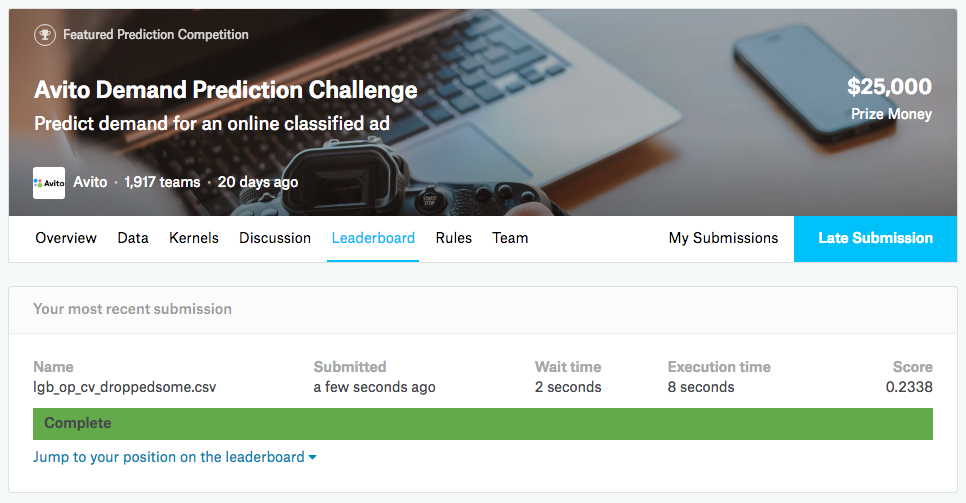

In [39]:
from IPython.display import Image
Image("./processeddata/images/LBOOST_drop5.png")

Plot feature importances...


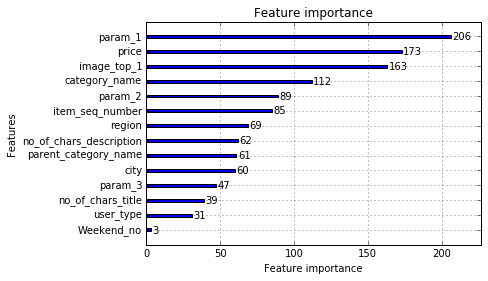

In [40]:
import matplotlib.pyplot as plt
print('Plot feature importances...')
ax = lgb.plot_importance(gbm_best3, max_num_features=18)
plt.show()

In [80]:
drop = ['Weekend_no','user_type','no_of_chars_title','day','user_id','Weekday','image_status','no_of_words_title','no_of_words_description']

In [81]:
## dropping more just to see the affect 

In [82]:
## remove some features                                                                                                 
trainless = train.drop(drop,axis=1)

In [83]:
trainless.head()

,item_id,category_name,city,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,no_of_chars_description,deal_probability
0,b912c3c6a6ad,42,462,12,2,249,112,1217,4,400.0,19,Кокоби(кокон для сна),108,0.12789
1,2dac0150717d,22,1314,2722,19,122,112,1217,2,3000.0,17,Стойка для Одежды,73,0.00000
2,ba83aefab5dc,2,1290,2259,9,84,112,1217,0,4000.0,16,Philips bluray,168,0.43177
3,02996f1dd2ea,42,950,2837,286,38,112,1217,4,2200.0,21,Автокресло,38,0.80323
4,7c90be56d2ab,0,318,1407,3,278,124,46,6,40000.0,4,"ВАЗ 2110, 2003",44,0.20797


In [84]:
x = trainless.iloc[:,0:trainless.shape[1]-1]
y = trainless.iloc[:,-1]
x.drop('title',axis = 1, inplace= True)
x.drop('item_id',axis = 1, inplace= True)

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [86]:
## from here
gbm_best3 = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=1,
                        n_estimators=40)

In [87]:
%%time
gbm_best3.fit(x, y,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

[1]	valid_0's l2: 0.0571882	valid_0's RMSLE: 0.178462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0560763	valid_0's RMSLE: 0.176872
[3]	valid_0's l2: 0.0553961	valid_0's RMSLE: 0.175768
[4]	valid_0's l2: 0.0551125	valid_0's RMSLE: 0.175359
[5]	valid_0's l2: 0.0547112	valid_0's RMSLE: 0.174811
[6]	valid_0's l2: 0.0545156	valid_0's RMSLE: 0.174434
[7]	valid_0's l2: 0.0543769	valid_0's RMSLE: 0.17422
[8]	valid_0's l2: 0.0542347	valid_0's RMSLE: 0.173932
[9]	valid_0's l2: 0.0540419	valid_0's RMSLE: 0.173583
[10]	valid_0's l2: 0.0539358	valid_0's RMSLE: 0.173442
[11]	valid_0's l2: 0.0538243	valid_0's RMSLE: 0.173267
[12]	valid_0's l2: 0.0537198	valid_0's RMSLE: 0.173103
[13]	valid_0's l2: 0.0536316	valid_0's RMSLE: 0.17298
[14]	valid_0's l2: 0.053559	valid_0's RMSLE: 0.172858
[15]	valid_0's l2: 0.0534314	valid_0's RMSLE: 0.172676
[16]	valid_0's l2: 0.0533575	valid_0's RMSLE: 0.172555
[17]	valid_0's l2: 0.0532933	valid_0's RMSLE: 0.172438
[18]	valid_0's l

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=40,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [88]:
testless = test.drop(drop,axis=1)
testless.head()

,category_name,city,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,no_of_chars_description
0,10,318,1137,66,110,198,74,4,0.0,4,23
1,5,993,3063,4,119,112,1217,8,3000.0,19,154
2,2,151,2178,15,318,112,1217,0,15000.0,12,233
3,4,1319,3063,70,108,131,1217,2,4500.0,18,155
4,42,243,6,15,102,112,1217,4,4900.0,14,106


In [89]:
%%time
predcited_test_lgb3 = gbm_best3.predict(testless, num_iteration=40)


CPU times: user 2.31 s, sys: 81.3 ms, total: 2.39 s
Wall time: 757 ms


In [90]:
predcited_test_lgb3.shape
testdata = pd.read_csv('test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdatai = testdata.index

(508438,)

In [72]:
testdata = pd.read_csv('test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdatai = testdata.index

In [91]:
lgboop = pd.DataFrame(predcited_test_lgb3,columns=["deal_probability"],index=testdatai)

In [92]:
lgboop["deal_probability"] = lgboop["deal_probability"].clip(0.0, 1.0 ) # Between 0 and 1



In [93]:
print all(i > 1.0 for i in lgboop.values)
print all(i < .0 for i in lgboop.values)

False
False


In [94]:
lgboop.to_csv("./processeddata/lgb_op_cv_droppedsomemore3.csv",index=True,header=True)

In [95]:
lgboop.head()

,deal_probability
item_id,
6544e41a8817,0.117316
65b9484d670f,0.281698
8bab230b2ecd,0.213025
8e348601fefc,0.038126
8bd2fe400b89,0.202451


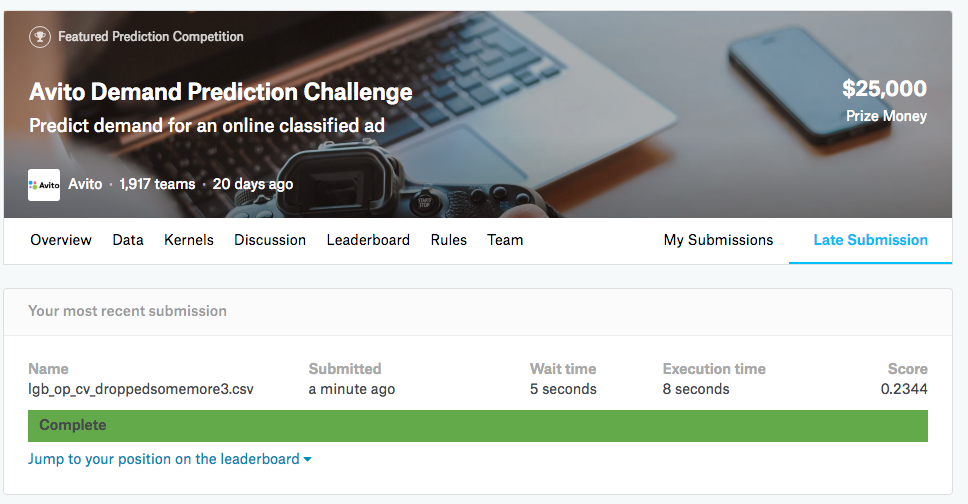

In [98]:
from IPython.display import Image
Image("./processeddata/images/LBOOST_drop4.png")

Plot feature importances...


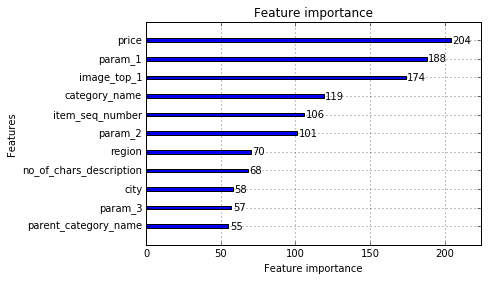

In [97]:
import matplotlib.pyplot as plt
print('Plot feature importances...')
ax = lgb.plot_importance(gbm_best3, max_num_features=18)
plt.show()

##### UNFORTUNATELY dosen't improve any more 